# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
from tensorflow.keras.models import load_model

# from tensorflow.keras.layers import LSTM
import tensorflow as tf
import copy
import pandas as pd
from nmp.dataset import pyplot_piano_roll, write_midi
import matplotlib.pyplot as plt
import time
import pypianoroll

from tensorflow.keras.callbacks import TensorBoard, CSVLogger

import keras.metrics
from datetime import datetime
import seaborn as sns

from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp import plotter

import math
from pypianoroll import Multitrack, Track

import random

Using TensorFlow backend.


# Initialize Variable

In [2]:
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook

PLOTS = P / 'plots'  # Plots path
BS = 64
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12  # Downsampling factor
D = "data/POP909" # Dataset
# MODEL = 'model-LSTM-24-10-12'
# MODEL = 'chorales-ff-2'
MODEL = 'ff-2.h5'

LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

# TensorFlow stuff
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [17]:
str(P / 'models' / MODEL)

'/home/cuy/NMP/models/ff-2.h5'

# Load Model

In [4]:
# Load model.
# model = load_model(filepath=str(P / 'models' / MODEL),
#                    compile=True)
# model.summary()

tempo = 120

model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy', mod.f1])


In [10]:
# model.load_weights(tf.train.latest_checkpoint(str(P / 'models' / MODEL)))
model.load_weights(tf.train.latest_checkpoint(str(P / 'models' / 'training_checkpoints' / '20220610-171152')))
model.build(tf.TensorShape([1, None]))
model.summary()

# temporary way since loading won't work
# model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
# mod.compile_model(model, 'binary_crossentropy', 'adam',
#                   metrics=['accuracy', mod.f1, keras.metrics.Precision(), keras.metrics.Recall()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 640)               21120     
Total params: 33,472
Trainable params: 33,472
Non-trainable params: 0
_________________________________________________________________


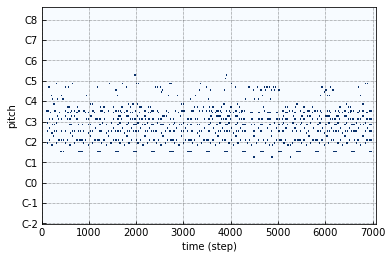

In [23]:
# midi-test

TRACK = 'test/001.mid'
FILE = D + '/' + TRACK
test_file = dataset.import_one(str(FILE), 24)
test_file = test_file[:, LOW_LIM:HIGH_LIM]
pyplot_piano_roll(test_file, low_lim=+LOW_LIM, high_lim=HIGH_LIM)
STOP = 960

In [24]:
test_list = [P / FILE]
test = dataset.Dataset(test_list, P / D,  fs=FS, bl=0, quant=Q)
test.build_dataset("test", step=st, t_step=num_ts, steps=st, down=DOWN,
                   low_lim=LOW_LIM, high_lim=HIGH_LIM)

Building test dataset (1 files)


In [25]:
print(test.dataset[0].shape)

inter_size = 5
interruptions = [10, 20, 30, 40, 50, 60, 70]

final = copy.deepcopy(test.dataset[0][:, 0, :])

(571, 10, 64)


In [26]:
# Predictions
predictions = model.predict(x=test.dataset[0])#, batch_size=BS)
predictions_bin = dataset.ranked_threshold(predictions, steps=10,
                                           how_many=3)

for t in interruptions:
    for s in range(inter_size):
        final[t+s, :] = predictions_bin[t, s*64:(s+1)*64]

In [27]:
# Save piano roll
f0 = copy.deepcopy(final)
write_midi(f0, str(P / 'audio_output' / 'test.mid'),
           LOW_LIM, HIGH_LIM, tempo=tempo)

In [28]:
plt.show()

In [29]:
[P / FILE]

[PosixPath('/home/cuy/NMP/data/POP909/test/001.mid')]